In [35]:
docs = ["""God made mud. God got lonesome. So God said to some of the mud, \"Sit up!\" 
        \"See all I\'ve made,\" said God, \"the hills, the sea, the sky, the stars.\"
        And I was some of the mud that got to sit up and look around. Lucky me, lucky mud.""",
        
        """I, mud, sat up and saw what a nice job God had done.
        Nice going, God. Nobody but you could have done it, God! I certainly couldn\'t have.
        I feel very unimportant compared to You.
        The only way I can feel the least bit important is to
        think of all the mud that didn't even get to sit up and look around.
        I got so much, and most mud got so little. Thank you for the honor!""",
        
        """Now mud lies down again and goes to sleep. What memories for mud to have!
        What interesting other kinds of sitting-up mud I met! I loved everything I saw! Good night.
        I will go to heaven now. I can hardly wait... To find out for certain what my wampeter was...
        And who was in my karass...And all the good things our karass did for you. Amen."""]

corpus = '\n\n'.join(docs)

In [36]:
#
# Build Co-occurence Matrix, A
#

import itertools

# external
import numpy as np
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.util import ngrams
from nltk.tokenize import sent_tokenize, word_tokenize

def process_text(text):
	""" return list of lowercase alphabetic words from text """
	tokenizer = RegexpTokenizer(r'\w+')
	return tokenizer.tokenize(text.lower())

def ngram_tupples(corpus, n):
	""" Create ngram tupples by sentence. Where n is the distance between words in a sentence. """
	sentences = sent_tokenize(corpus)

	pairs = []
	for s in sentences:
		unique_tokens = process_text(s)
		pairs.extend(ngrams(unique_tokens,n))

	return pairs

def get_unique_words(corpus):
	return list(set(process_text(corpus)))

def w2id_id2w_maps(unique_words):
	""" return both dictonaries for mapping between words and ids """
	id2w = {i:w for i,w in enumerate(unique_words)}
	w2id = {w:i for i,w in id2w.items()}
	return w2id, id2w

def ngram_inc_amt(n):
	""" return float for increment weight of pair occurence n distance appart. \nWeight increment ~ 1/n """
	return 1/float(n**2)

def words2ids(words, w2id):
	""" return list of ids inplace of list of words using w2id dictionary """
	return [w2id[w] for w in words]

def cooccurence_pair_of_distance(sentence_list, d):
    """ return list of unique coocurence pairs of distace d """

    all_ngrams = ngrams(sentence_list,d)

    all_pairs = []
    for t in all_ngrams:
        if len(t) > 1:
            all_pairs.extend(list(itertools.combinations(t, 2)))

    return list(set(all_pairs))

def break_corpus(corpus):
    """ Build Cooccurence Matrix. Return A, n, w2id, id2w """

    unique_words = get_unique_words(corpus)
    n = len(unique_words)
    w2id, id2w = w2id_id2w_maps(unique_words)

    #create empty cooccurence matrix
    #A = np.zeros([n,n],np.float32)
    A = np.ones([n,n],np.float32)

    #compute cooccurence matrix
    sentences = sent_tokenize(corpus)
    for s in sentences:
        s = process_text(s)
        max_distance = len(s) + 1
        s = [w2id[w] for w in s]	#convert words to ids

        for d in range(2,max_distance):
            pairs = cooccurence_pair_of_distance(s, d)

            #update cooccurence matrix for each pair
            for p in pairs:
                A[p[0],p[1]] += ngram_inc_amt(d)
                A[p[1],p[0]] += ngram_inc_amt(d)

    return A, n, w2id, id2w

A, n, w2id, id2w = break_corpus(corpus)

In [37]:

"""
	Normalize and clean text methods
"""
import logging
import string
import math

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk import FreqDist
from nltk.tag import pos_tag

# logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def is_stopword(word):
	""" Return True of word is in stop word list """
	stop_words = nltk.corpus.stopwords.words('english')
	return word in stop_words

def is_punctuation(word):
	return len(word) == 1 and word in string.punctuation

def is_number(word):
	try:
		float(word)
		return True
	except ValueError:
		logger.debug('ValueError is_number')
 
	try:
		import unicodedata
		unicodedata.numeric(word)
		return True
	except (TypeError, ValueError):
		logger.debug('ValueError is_number')
	 
	return False

def is_shorter(word,n=3):
	if len(word) < n:
		return True
	return False

def stem(word):
	ps = PorterStemmer()
	return ps.stem(word)

def clean_word(raw_word):
	""" Takes string converts to lower case, stems 
	and returns empty string if word is stop word, 
	punctation or is less than 3 characters long """

	raw_word = raw_word.lower()
	if is_stopword(raw_word) or is_punctuation(raw_word) or is_shorter(raw_word) or is_number(raw_word):
		word = ""
	else:
		word = stem(raw_word)
	return word

def remove_short_and_stopwords(token_list):
	filtered_token_list = []
	for t in token_list:
		if is_stopword(t) or is_punctuation(t) or is_shorter(t) or is_number(t):pass
		else: filtered_token_list.append(t)
	return filtered_token_list


In [38]:
def rank_most_related_words(A, w2id, id2w, w1):
    col = A[:,w2id[w1]].tolist()

    list_of_index_value_tuples = list(zip(list(range(len(col))),col))
    #(colindex,value)
    sorted_indexs_value_tuples = sorted(list_of_index_value_tuples, key=lambda x: x[1])
    sorted_indexs_value_tuples.reverse()
    indexs, values = zip(*sorted_indexs_value_tuples)
    ranked_words = [id2w[i] for i in indexs]
    return ranked_words

# rank_most_related_words(A,w2id, id2w, 'aa')

def related_words_list_filtered_decending(A, w2id, id2w, w1):
    raw_related_words = rank_most_related_words(A, w2id, id2w, w1)
    filtered_related_words = remove_short_and_stopwords(raw_related_words)
    return filtered_related_words

related_words_list_filtered_decending(A,w2id, id2w, 'god')

['said',
 'made',
 'done',
 'job',
 'nice',
 'going',
 'got',
 'hills',
 'mud',
 'sea',
 'lonesome',
 'saw',
 'could',
 'see',
 'sky',
 'stars',
 'sat',
 'sit',
 'nobody',
 'honor',
 'sleep',
 'wait',
 'least',
 'god',
 'met',
 'important',
 'amen',
 'memories',
 'get',
 'around',
 'sitting',
 'bit',
 'hardly',
 'goes',
 'interesting',
 'feel',
 'heaven',
 'kinds',
 'certain',
 'way',
 'everything',
 'things',
 'lucky',
 'wampeter',
 'unimportant',
 'much',
 'loved',
 'thank',
 'look',
 'find',
 'little',
 'certainly',
 'good',
 'think',
 'night',
 'even',
 'lies',
 'compared',
 'karass']

In [39]:
#internal
import random

#external
import numpy as np

"""
Matrix Decomposition
	Method 1) Singular Value Decomposition of Forced Square Symmetric Positive Definite Matrix
	Method 2) Eigen Decomposition of Forced Square Symmetric Positive Matrix
	Method 3) Stocastic Gradient Decent Decomposition
"""

# check symmetry of matrix up to some tolerance
def check_symmetric(a, tol=1e-8):
    return np.allclose(a, a.T, atol=tol)

#force square symetric matrix to symetric positive definite matrix
def to_positive_definite(S):
    """ Take absolute value of S and update diagnol entries to make a diagonally dominant matrix with diagonal entries greater than 0. """
    # take absolute value of S
    S = np.absolute(S)

    # Sum rows in S
    new_diagonals = S.sum(axis=1)

    #replace diagnols in S
    np.fill_diagonal(S, new_diagonals)

    return S

"""
####################################################################################
# Singular Value Decomposition of Forced Square Symmetric Positive Definite Matrix #
####################################################################################
1.) Force Cooccurence Matrix A to Positive Definite Matrix
    " A diagonally dominant(by rows) symetric matrix with diagonal elements all greater than zero is positive definite."
    Take symmetric matrix and make diagonally dominant with diagnonal entries greater than 0
2.) Square Symmetric Positive Definite Matrix Decomposition
    " If A is positive definite, then A = QLQt = UDV (where U=V=Q and L=D) can be written as A = WWt where W = Qsqrt(L) "
    -SVD: A=UDV, W = Vsqrt(diagnol(D))
    Find V and D from singular value decomposition of A
    return W = Vsqrt(D)
overview of code:
    #
    # force symmetric matrix to positive definite matrix
    #
    # take absolute value of A
    A = np.absolute(A)
    # Sum rows in a
    new_diagonals = A.sum(axis=1)
    #replace diagnols in A
    np.fill_diagonal(A, new_diagonals)
    #
    # decompose positive definite matrix
    #
    # singular value decomposition
    U, D, V = np.linalg.svd(A, full_matrices=False)
    #
    # compute W from V and D of singular value decomposition
    #
    # Create matrix W = Vtsqrt(diagnol(D)) #why Vt?
    W = np.dot(np.transpose(V), np.sqrt(np.diag(D)))
    #A = WWt
"""

def svd_spd_decomposition(P):
    """ return M such that P = MMt, where matrix parameter P is SPD """
    # Assert Matrix P is symetric
    assert check_symmetric(P)

    # singular value decomposition
    U, D, V = np.linalg.svd(P, full_matrices=False)

    # Create matrix W = Vtsqrt(diagnol(D)) #why Vt?
    M = np.dot(np.transpose(V), np.sqrt(np.diag(D)))

    return M

def spd_decomposition(S):
	""" Force Cooccurence Matrix A to Positive Definite Matrix and decompose into W such that A = WWt. """
	P = to_positive_definite(S)
	M = svd_spd_decomposition(P)
	return M

#
# Perform Symmetric Positive Definite Decomposition
#

W = spd_decomposition(A)

print("\n\n\nSymmetric Positive Definite Decomposition:\n")
print("\n\nA:")
print (A)
print("\n\nA2 (modified into SPD):\n")
print(to_positive_definite(A))
print("\nWWt:\n")
print(np.dot(W, np.transpose(W)))




Symmetric Positive Definite Decomposition:



A:
[[1.        1.        1.        ... 1.        1.        1.       ]
 [1.        1.        1.        ... 1.        1.        1.       ]
 [1.        1.        1.1984842 ... 1.        1.        1.       ]
 ...
 [1.        1.        1.        ... 1.        1.        1.       ]
 [1.        1.        1.        ... 1.        1.        1.       ]
 [1.        1.        1.        ... 1.        1.        1.       ]]


A2 (modified into SPD):

[[102.88062   1.        1.      ...   1.        1.        1.     ]
 [  1.      101.42222   1.      ...   1.        1.        1.     ]
 [  1.        1.      106.71744 ...   1.        1.        1.     ]
 ...
 [  1.        1.        1.      ... 102.2087    1.        1.     ]
 [  1.        1.        1.      ...   1.      100.81972   1.     ]
 [  1.        1.        1.      ...   1.        1.      101.70223]]

WWt:

[[102.88062      0.9999993    0.99999917 ...   0.99999845   0.99999994
    1.0000001 ]
 [  0.99999

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in sqrt


In [56]:
import random

n = len(w2id.items())-1 # sample size
m = 2 # top m most related words
random_indexs = random.sample(range(0, len(id2w)-1), n)
corpus_terms = [id2w[i] for i in random_indexs]

#corpus_terms = ['republican','flynn','trump','2016','lied','biblical','drug','communist','criminal','russia','chinese','inauguration','obama','nuclear','spine','twitter','students','unanimous','hillary','peace','deal', 'clearances','financial','failed','prescription','unprecedented','election','ship','taliban','military']
#corpus_terms = ['republican','ship','drug','communist','taliban','flynn','russia','inauguration','trump','obama','spine','2016','twitter','unprecedented','election','unanimous','hillary','prescription','peace','financial']

# list of lists where the first index is a corpus term and the trailing indexs are its ranked related words
list_of_related_word_lists = []
for t in corpus_terms:
    print('\nterm: %s' % t)
    related_terms = related_words_list_filtered_decending(A, w2id, id2w, t)
    print(related_terms[:m])

    list_of_related_word_lists.append(related_terms[:m])

np_related_words = np.array(list_of_related_word_lists)

related_words_network = [[term,related_terms] for term,related_terms in zip(corpus_terms, np_related_words.tolist())]

#edges_related_words_network = [(term,r) for r in term, related_terms in ]
edges_related_words_network = []
for term,related_terms in related_words_network:
    edges_cur_related_word = [(term, r) for r in related_terms]
    edges_related_words_network += edges_cur_related_word

edges_related_words_network
    


term: me
['lucky', 'mud']

term: now
['mud', 'heaven']

term: important
['bit', 'least']

term: look
['around', 'sit']

term: lonesome
['got', 'god']

term: t
['even', 'get']

term: way
['feel', 'least']

term: said
['god', 'made']

term: go
['heaven', 'honor']

term: karass
['things', 'good']

term: some
['mud', 'said']

term: other
['interesting', 'kinds']

term: in
['karass', 'wampeter']

term: interesting
['kinds', 'sitting']

term: will
['heaven', 'honor']

term: our
['karass', 'things']

term: think
['important', 'bit']

term: done
['god', 'could']

term: amen
['honor', 'stars']

term: it
['god', 'done']

term: lucky
['mud', 'lucky']

term: sit
['mud', 'look']

term: had
['god', 'done']

term: even
['get', 'sit']

term: didn
['even', 'mud']

term: little
['got', 'mud']

term: hardly
['wait', 'find']

term: to
['sit', 'mud']

term: loved
['everything', 'saw']

term: much
['got', 'mud']

term: down
['lies', 'mud']

term: you
['could', 'thank']

term: around
['look', 'sit']

term: 

[('me', 'lucky'),
 ('me', 'mud'),
 ('now', 'mud'),
 ('now', 'heaven'),
 ('important', 'bit'),
 ('important', 'least'),
 ('look', 'around'),
 ('look', 'sit'),
 ('lonesome', 'got'),
 ('lonesome', 'god'),
 ('t', 'even'),
 ('t', 'get'),
 ('way', 'feel'),
 ('way', 'least'),
 ('said', 'god'),
 ('said', 'made'),
 ('go', 'heaven'),
 ('go', 'honor'),
 ('karass', 'things'),
 ('karass', 'good'),
 ('some', 'mud'),
 ('some', 'said'),
 ('other', 'interesting'),
 ('other', 'kinds'),
 ('in', 'karass'),
 ('in', 'wampeter'),
 ('interesting', 'kinds'),
 ('interesting', 'sitting'),
 ('will', 'heaven'),
 ('will', 'honor'),
 ('our', 'karass'),
 ('our', 'things'),
 ('think', 'important'),
 ('think', 'bit'),
 ('done', 'god'),
 ('done', 'could'),
 ('amen', 'honor'),
 ('amen', 'stars'),
 ('it', 'god'),
 ('it', 'done'),
 ('lucky', 'mud'),
 ('lucky', 'lucky'),
 ('sit', 'mud'),
 ('sit', 'look'),
 ('had', 'god'),
 ('had', 'done'),
 ('even', 'get'),
 ('even', 'sit'),
 ('didn', 'even'),
 ('didn', 'mud'),
 ('little', 

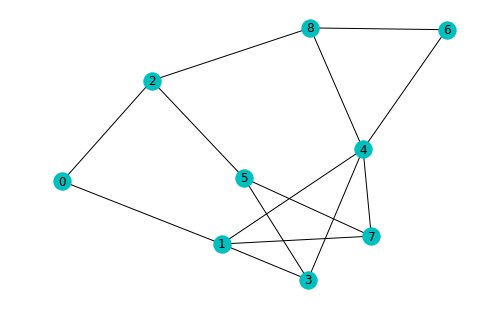

In [57]:
np_related_words

import plotly.plotly as py
from plotly.graph_objs import *
import networkx as nx

import matplotlib.pyplot as plt

G=nx.Graph()#  G is an empty Graph

Nodes=range(9)
G.add_nodes_from(Nodes)
Edges=[(0,1), (0,2), (1,3), (1,4), (1,7), (2,5), (2,8), (3, 4), (3,5),(4,6), (4,7), (4,8), (5,7)]
G.add_edges_from(Edges)
G.add_edge(6,8)

nx.draw(G, node_color='c',edge_color='k', with_labels=True)
plt.show()

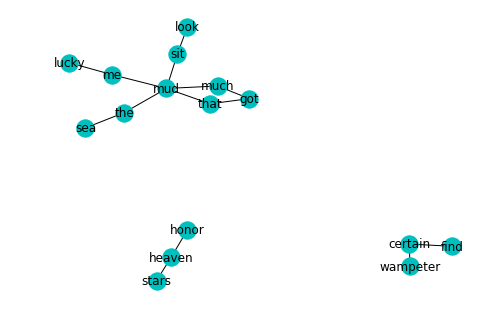

['other', 'me', 'out', 'thank', 'god', 'and', 'have']


In [70]:
import plotly.plotly as py
from plotly.graph_objs import *
import networkx as nx

import matplotlib.pyplot as plt

sample_size = 7

G=nx.Graph()#  G is an empty Graph

random_terms_sample = list(random.sample(corpus_terms, sample_size))
Nodes= random_terms_sample
G.add_nodes_from(Nodes)
Edges= [e for e in edges_related_words_network if e[0] in random_terms_sample]
G.add_edges_from(Edges)

nx.draw(G, node_color='c',edge_color='k', with_labels=True)
plt.show()

print(list(random.sample(corpus_terms, sample_size)))